In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import regex as re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
data=pd.read_csv("spam.csv",encoding="ISO-8859-1")
data_set=data[['v2','v1']]
data_set.head(5)

def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords.words('english'):
            final_text.append(i.strip())
    return " ".join(final_text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def str_lower(text):
    return text.lower()

def denoise_text(text):
    text = alpha_num(text)
    text = remove_stopwords(text)
    text = remove_URL(text)
    text = remove_html(text)
    text = strip_html(text)
    text = simple_stemmer(text)
    text = remove_between_square_brackets(text)
    text = str_lower(text)
    return text




data_set['review']=data_set['v2'].apply(denoise_text)
label_mapping = {'spam': 1, 'ham': 0}

data_set['v1'] = data_set['v1'].map(label_mapping)


data_set['review']

<ipython-input-64-00c892ec609f>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['review']=data_set['v2'].apply(denoise_text)
<ipython-input-64-00c892ec609f>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['v1'] = data_set['v1'].map(label_mapping)


,v2,v1,review
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,2nd time tri 2 contact u u 750 pound prize 2 c...
5568,Will Ì_ b going to esplanade fr home?,0,b go esplanad fr home
5569,"Pity, * was in mood for that. So...any other s...",0,piti mood soani suggest
5570,The guy did some bitching but I acted like i'd...,0,guy bitch act like id interest buy someth els ...


In [ ]:
data_set['review'][2]

'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri questionstd txt ratetc appli 08452810075over18'

In [ ]:
max_len = data_set['review'].apply(len).max()
max_len

477

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
!pip install keras


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, LSTM
from keras.models import Model
from keras.layers import Input, Dense, Flatten

features=data_set['review']
labels=data_set['v1']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

Tok_data = Tokenizer(oov_token='<00v>')
Tok_data.fit_on_texts(X_train)

encoded_train = Tok_data.texts_to_sequences(X_train)
encoded_test = Tok_data.texts_to_sequences(X_test)

max_length = 477


padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

vocab_size = len(Tok_data.word_index) + 1



None


In [ ]:

embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))
len(Tok_data.word_index)

KeyboardInterrupt: ignored

In [ ]:
len(Tok_data.word_index)

6568

In [ ]:

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in Tok_data.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(6569, 100)

In [ ]:
embedding_layer = Embedding(vocab_size,
                            100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
p = Dense(1, activation='sigmoid')(x)

model_glove = Model(sequence_input, p)

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_glove.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 477)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 477, 100)          656900    
                                                                 
 flatten_6 (Flatten)         (None, 47700)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 47701     
                                                                 
Total params: 704601 (2.69 MB)
Trainable params: 47701 (186.33 KB)
Non-trainable params: 656900 (2.51 MB)
_________________________________________________________________


In [ ]:

embedding_layer = Embedding(vocab_size,
                            100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=True)
sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_covl= Conv1D(256, 5, activation='relu')(embedded_sequences)
l_pool3 = MaxPooling1D(5)(l_covl)
l_flat = Flatten()(l_pool3)
l_drop1 = Dropout(0.2)(l_flat)
l_dense = Dense(180, activation='relu')(l_drop1)
l_drop2 = Dropout(0.2)(l_dense)
preds = Dense(1, activation='sigmoid')(l_drop2)

model_cnn = Model(sequence_input, preds)
model_cnn.compile(loss='binary_crossentropy',
                  optimizer='ADAM',
                  metrics=['accuracy'])
model_cnn.summary()
print(y_train.dtypes)
print(y_test.dtypes)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 477)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 477, 100)          656900    
                                                                 
 conv1d_3 (Conv1D)           (None, 473, 256)          128256    
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 94, 256)           0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 24064)             0         
                                                                 
 dropout_6 (Dropout)         (None, 24064)             0         
                                                           

In [ ]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

history_cnn = model_cnn.fit(padded_train, y_train, epochs=30, batch_size=512,validation_data=(padded_test, y_test), verbose=1)


print(len(padded_train))
print(len(y_train))



Epoch 1/30
8/8 [==============================] - 62s 8s/step - loss: 0.4209 - accuracy: 0.8510 - val_loss: 0.2683 - val_accuracy: 0.8678
Epoch 2/30
8/8 [==============================] - 42s 5s/step - loss: 0.2566 - accuracy: 0.8841 - val_loss: 0.2263 - val_accuracy: 0.8870
Epoch 3/30
8/8 [==============================] - 42s 5s/step - loss: 0.1920 - accuracy: 0.9200 - val_loss: 0.1677 - val_accuracy: 0.9468
Epoch 4/30
8/8 [==============================] - 44s 5s/step - loss: 0.1273 - accuracy: 0.9626 - val_loss: 0.1169 - val_accuracy: 0.9611
Epoch 5/30
8/8 [==============================] - 44s 5s/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.0978 - val_accuracy: 0.9683
Epoch 6/30
8/8 [==============================] - 42s 5s/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0853 - val_accuracy: 0.9767
Epoch 7/30
8/8 [==============================] - 46s 6s/step - loss: 0.0441 - accuracy: 0.9867 - val_loss: 0.0817 - val_accuracy: 0.9785
Epoch 8/30
8/8 [==================

53/53 [==============================] - 4s 78ms/step - loss: 0.1225 - accuracy: 0.9815
Accuracy: 98.145932
Loss: 12.250542


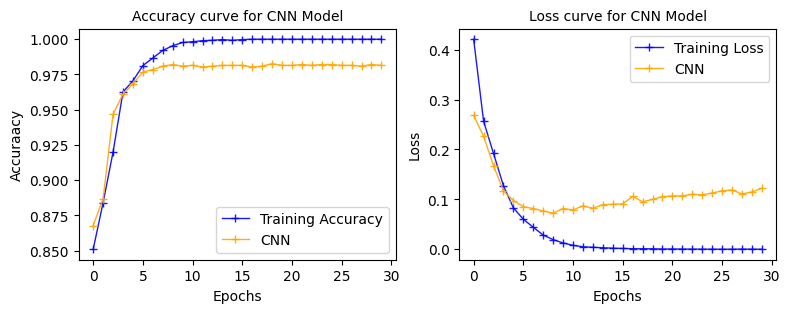

In [ ]:
loss, accuracy = model_cnn.evaluate(padded_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.plot(history_cnn.history['accuracy'], marker='+', label='Training Accuracy', c='blue', lw='1', alpha=0.9)
plt.plot(history_cnn.history['val_accuracy'], marker='+', label='CNN', c='orange', lw='1', alpha=0.9)
plt.title('Accuracy curve for CNN Model', loc='center', fontsize=10)
plt.xlabel("Epochs")
plt.ylabel('Accuraacy')
plt.legend()

plt.subplot(122)
plt.plot(history_cnn.history['loss'], marker='+', label='Training Loss', c='blue', lw='1', alpha=0.9)
plt.plot(history_cnn.history['val_loss'], marker='+', label='CNN', c='orange', lw='1', alpha=0.9)
plt.title('Loss curve for CNN Model', loc='center', fontsize=10)
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
embedding_layer= Embedding(vocab_size,
                           100,
                           weights=[embedding_matrix],
                           input_length=max_length,
                           trainable=True)
sequence_input= Input(shape=(max_length,), dtype='int32')
embedded_sequences=embedding_layer(sequence_input)

sequence_input= Input(shape=(max_length,),dtype='int32')
embedded_sequences=embedding_layer(sequence_input)
x=LSTM(units=64)(embedding_layer(sequence_input))

x= Dropout(0.2)(embedded_sequences)
x= Conv1D(64 ,5 , activation='relu')(x)
x= Dense(1 , activation='sigmoid')(x)
x= MaxPooling1D(pool_size=4)(x)
x= (LSTM(64))(x)
p= Dense(1,activation='sigmoid')(x)
model_cnnlstm= Model(sequence_input, p)
model_cnnlstm.compile(optimizer='adam' , loss='binary_crossentropy',  metrics=['accuracy'])
model_cnnlstm.summary()

In [ ]:
embedding_layer = Embedding(vocab_size,
                           100,
                           weights=[embedding_matrix],  # Use 'weights' instead of 'weight'
                           input_length=max_length,
                           trainable=True)

sequence_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Dropout(0.2)(embedded_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(64)(x)
p = Dense(1, activation='sigmoid')(x)

model_cnnlstm = Model(sequence_input, p)
model_cnnlstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnnlstm.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 477)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 477, 100)          656900    
                                                                 
 dropout_8 (Dropout)         (None, 477, 100)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 473, 64)           32064     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 118, 64)           0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                           

In [ ]:
spam_message = "Congratulations! You have all been selected to receive a free gift card worth $1000. Click on this link [Link] to claim your reward now. Limited time offer, so act fast! Don't miss out on this amazing opportunity."
encoded_spam = Tok_data.texts_to_sequences([spam_message])
padded_spam = pad_sequences(encoded_spam, maxlen=max_length, padding='post')

prediction_spam = model_cnn.predict(padded_spam)

# Prediction continued
threshold = 0.5
if prediction_spam > threshold :
  print("this is spam")
else :
  print("this is not spam ")


1/1 [==============================] - 0s 44ms/step
this is spam


In [ ]:
import pickle

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(Tok_data, handle, protocol=pickle.HIGHEST_PROTOCOL)